<a href="https://colab.research.google.com/github/donusKim/Sales_Forecasting/blob/master/Sales_Forecasting(with%20CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
trend=pd.read_csv("./gdrive/My Drive/롯데백화점/naver_trend.csv",encoding="ms949" )

FileNotFoundError: ignored

In [ ]:
import numpy as np
import pandas as pd


df=pd.read_csv("./gdrive/My Drive/롯데백화점/purchase_data.csv",encoding="ms949" )
temp=pd.read_csv("./gdrive/My Drive/롯데백화점/기온2.csv",encoding="ms949").set_index(["지점"])
rain=pd.read_csv("./gdrive/My Drive/롯데백화점/강수량2.csv",encoding="ms949").set_index(["지점"])
cpi=pd.read_csv("./gdrive/My Drive/롯데백화점/소비자물가지수.csv",encoding="ms949").set_index(["시도별"])
temp.drop("160",axis=1,inplace=True)
rain.drop("160",axis=1,inplace=True)

# 주데이터 만들기
import datetime
df["days"]=df['date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))
df["days"]=df["days"]-np.datetime64('2016-07-03')
df["week"]=df["days"]/7

# 주데이터 만들기
import datetime
df["days"]=df['date'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))
df["days"]=df["days"]-np.datetime64('2016-07-03')
df["week"]=df["days"]/7


import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from datetime import date, timedelta
import gc


## 취소매출 제거하는 나름의 방법(오차가 있음)###
df["absolute"]=abs(df["pur_amt"])
df=df.drop_duplicates(["cus_id","absolute"], keep='first')
new_df=df[["point","week","brand","absolute"]]


####점 이름 바꿔주기 ####
substitutions = {1.0: "본점",2.0: "잠실점",5.0: "부산본점",6.0: "관악점",8.0: "분당점",10.0: "영등포점",11.0: "일산점",13.0: "강남점",17.0: "창원점",22.0: "노원점",28.0: "건대스타점",333.0: "광복점"
                 ,341.0: "평촌점",344.0: "인천터미널점"}        
new_df=new_df.replace(substitutions)


new_df["week"]=new_df["week"].apply(lambda x: x.days)

new_df=new_df[(new_df["week"]!=160) & (new_df["week"]!=-1) ]

#영등포점 생긴 이상한애들 제거
new_df.drop(28391,axis=0,inplace=True)
new_df.drop(224708,axis=0,inplace=True)

#머시러닝 전처리 위해 reindex
new_df=new_df.set_index(["point","brand","week"]).groupby(level=[0,1,2])['absolute'].agg({'sum':np.sum}).unstack(level=-1).fillna(0)
new_df.columns=new_df.columns.get_level_values(1)

new_df=new_df[sorted(new_df.columns)]

#관악점, 인천터미널점 제거
new_df.drop("관악점",axis=0,inplace=True)
new_df.drop("인천터미널점",axis=0,inplace=True)


temp=temp.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
# rain은 min max 스케일링 말고 로그변환 적용해보기
rain=rain.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)

cpi.loc["전국"]=cpi.loc["경기도"]
cpi.index=["경기북부","서울","부산","인천","경기남부","창원"]
#인천제거
rain.drop("인천",axis=0,inplace=True)
cpi.drop("인천",axis=0,inplace=True)
temp.drop("인천",axis=0,inplace=True)


point=pd.read_csv("./gdrive/My Drive/롯데백화점/point_table.csv",encoding="ms949").set_index(["point_name"])


rain_new=pd.merge(point, rain,left_on='지역', right_index=True,how='left')
temp_new=pd.merge(point, temp,left_on='지역', right_index=True,how='left')
temp_new.drop("지역",axis=1,inplace=True)
rain_new.drop("지역",axis=1,inplace=True)

temp_reindex=temp_new.reindex(new_df.index.get_level_values(0))
rain_reindex=rain_new.reindex(new_df.index.get_level_values(0))


new_df.columns=pd.date_range(start='6/30/2016', periods=160, freq='W')
temp_reindex.columns=new_df.columns
temp_reindex.columns=new_df.columns


# 3년간 기록있는거만 활용
temp_reindex.index=new_df.index
rain_reindex.index=new_df.index


too_many_zero_index=new_df[((new_df['2016-07-03']==0) &(new_df['2016-07-10']==0) &(new_df['2016-07-17']==0)&(new_df['2016-07-24']==0)) | ((new_df['2019-06-30']==0) &(new_df['2019-07-07']==0) &(new_df['2019-07-14']==0)&(new_df['2019-07-21']==0)) ].index



temp_reindex=temp_reindex.loc[(new_df.index).difference(too_many_zero_index)]
rain_reindex=rain_reindex.loc[(new_df.index).difference(too_many_zero_index)]
df=new_df
new_df=new_df.loc[(new_df.index).difference(too_many_zero_index)]




#####  2016-07-03 ~~2019-07-21 까지 1주일씩(일~토)의 160주의 데이터를 알고리즘 수정 귀찮으니 임의의 160일 설정 하겠음!!

new_df.columns=pd.date_range(start='6/30/2016', periods=160, freq='D')

rain_reindex.columns=pd.date_range(start='6/30/2016', periods=160, freq='D')

temp_reindex.columns=pd.date_range(start='6/30/2016', periods=160, freq='D')


## '2016-06-30', '2016-07-01', '2016-07-02', '2016-07-03',
              # '2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07',
              # '2016-07-08', '2016-07-09',
              # ...  
              # '2016-11-27', '2016-11-28', '2016-11-29', '2016-11-30',
              # '2016-12-01', '2016-12-02', '2016-12-03', '2016-12-04',
              # '2016-12-05', '2016-12-06'


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [ ]:
new_df.index.levels[1]

Index(['라움', '마쥬', '바네사브루노', '산드로', '솔리드옴므', '시스템옴므', '에르메네질도 제냐', '엠포리오아르마니',
       '이자벨마랑', '자딕앤볼테르', '질스튜어트', '질스튜어트뉴욕', '타임옴므', '폴로랄프로렌'],
      dtype='object', name='brand')

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from datetime import date, timedelta
import gc


# Create validation and test data
def create_dataset(df,temp,rain, timesteps, first_pred_start, is_train=True, aux_as_tensor=False, reshape_output=0):
    #encoder = LabelEncoder()
    #items_reindex = items.reindex(df.index.get_level_values(1))
    #item_family = encoder.fit_transform(items_reindex['family'].values)
    #item_class = encoder.fit_transform(items_reindex['class'].values)
    #item_perish = items_reindex['perishable'].values

    #stores_reindex = stores.reindex(df.index.get_level_values(0))
    #store_nbr = df.reset_index().store_nbr.values - 1
    #store_cluster = stores_reindex['cluster'].values - 1
    #store_type = encoder.fit_transform(stores_reindex['type'].values)

    # item_mean_df = df.groupby('item_nbr').mean().reindex(df.index.get_level_values(1))
    brand_group_mean = df.groupby('brand').mean()
    point_group_mean = df.groupby('point').mean()
    # store_family_group_mean = df.join(items['family']).groupby(['store_nbr', 'family']).transform('mean')
    # store_family_group_mean.index = df.index

    #cat_features = np.stack([item_family, item_class, item_perish, store_nbr, store_cluster, store_type], axis=1)

    return create_dataset_part(df,temp,rain, brand_group_mean, point_group_mean, timesteps, first_pred_start, reshape_output, aux_as_tensor, is_train)

def train_generator(df,temp,rain, timesteps, first_pred_start,
    n_range=1, day_skip=7, is_train=True, batch_size=2000, aux_as_tensor=False, reshape_output=0, first_pred_start_2016=None):
    #encoder = LabelEncoder()
    #items_reindex = items.reindex(df.index.get_level_values(1))
    #item_family = encoder.fit_transform(items_reindex['family'].values)
    #item_class = encoder.fit_transform(items_reindex['class'].values)
    #item_perish = items_reindex['perishable'].values

    #stores_reindex = stores.reindex(df.index.get_level_values(0))
    #store_nbr = df.reset_index().store_nbr.values - 1
    #store_cluster = stores_reindex['cluster'].values - 1
    #store_type = encoder.fit_transform(stores_reindex['type'].values)

    # item_mean_df = df.groupby('item_nbr').mean().reindex(df.index.get_level_values(1))
    brand_group_mean = df.groupby('brand').mean()
    point_group_mean = df.groupby('point').mean()
    # store_family_group_mean = df.join(items['family']).groupby(['store_nbr', 'family']).transform('mean')
    # store_family_group_mean.index = df.index

    while 1:
        date_part = np.random.permutation(range(n_range))
        if first_pred_start_2016 is not None:
            range_diff = (first_pred_start - first_pred_start_2016).days / day_skip
            date_part = np.concat([date_part, np.random.permutation(range(range_diff, int(n_range/2) + range_diff))])

        for i in date_part:
            keep_idx = np.random.permutation(df.shape[0])[:batch_size]
            df_tmp = df.iloc[keep_idx,:]
            temp_tmp = temp.iloc[keep_idx,:]
            rain_tmp = rain.iloc[keep_idx,:]
           
            # item_mean_tmp = item_mean_df.iloc[keep_idx, :]

            pred_start = first_pred_start - timedelta(days=int(day_skip*i))

            # Generate a batch of random subset data. All data in the same batch are in the same period.
            yield create_dataset_part(df_tmp,temp_tmp, rain_tmp, brand_group_mean, point_group_mean, timesteps, pred_start, reshape_output, aux_as_tensor, True)

            gc.collect()

def create_dataset_part(df, temp,rain, brand_group_mean, point_group_mean, timesteps, pred_start, reshape_output, aux_as_tensor, is_train, weight=False):

    brand_mean_df = brand_group_mean.reindex(df.index.get_level_values(1))
    point_mean_df = point_group_mean.reindex(df.index.get_level_values(0))
    # store_family_mean_df = store_family_group_mean.reindex(df.index)

    X, y = create_xy_span(df, pred_start, timesteps, is_train)
    is0 = (X==0).astype('uint8')
    rain = rain[pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps)].values
    temp = temp[pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps)].values
    
    brand_mean, _ = create_xy_span(brand_mean_df, pred_start, timesteps, False)
    point_mean, _ = create_xy_span(point_mean_df, pred_start, timesteps, False)
    # store_family_mean, _ = create_xy_span(store_family_mean_df, pred_start, timesteps, False)
    # month_tmp = np.tile([d.month-1 for d in pd.date_range(pred_start-timedelta(days=timesteps), periods=timesteps+16)],
    #                       (X_tmp.shape[0],1))
    yearAgo, _ = create_xy_span(df, pred_start-timedelta(days=52), timesteps+4, False)
    quarterAgo, _ = create_xy_span(df, pred_start-timedelta(days=13), timesteps+4, False)
    #monthAgo, _ = create_xy_span(df, pred_start-timedelta(days=4), timesteps+4, False)
    if reshape_output>0:
        X = X.reshape(-1, timesteps, 1)
    if reshape_output>1:
        is0 = is0.reshape(-1, timesteps, 1)
        rain = rain.reshape(-1, timesteps, 1)
        temp = temp.reshape(-1, timesteps, 1)
        
        yearAgo = yearAgo.reshape(-1, timesteps+4, 1)
        quarterAgo = quarterAgo.reshape(-1, timesteps+4, 1)
        
        #monthAgo = quarterAgo.reshape(-1, timesteps+4, 1)
        brand_mean = brand_mean.reshape(-1, timesteps, 1)
        point_mean = point_mean.reshape(-1, timesteps, 1)
        # store_family_mean = store_family_mean.reshape(-1, timesteps, 1)

    #w = (cat_features[:, 2] * 0.25 + 1) / (cat_features[:, 2] * 0.25 + 1).mean()

  
    # Use when only 6th-16th days (private periods) are in the training output
    # if is_train: y = y[:, 5:]

    if weight: return ([X, is0,temp,rain, yearAgo, quarterAgo,brand_mean, point_mean], y)
    else: return ([X, is0,temp,rain, yearAgo, quarterAgo, brand_mean, point_mean], y)

def create_xy_span(df, pred_start, timesteps, is_train=True, shift_range=0):
    X = df[pd.date_range(pred_start-timedelta(days=timesteps), pred_start-timedelta(days=1))].values
    if (is_train & (date(2016,12,4)>pred_start)): y = df[pd.date_range(pred_start, periods=+4)].values
    else: y = None
    return X, y


# Calculate RMSE scores for all 16 days, first 5 days (fror public LB) and 6th-16th days (for private LB) 
def cal_score(Ytrue, Yfit):
	print([metrics.mean_squared_error(Ytrue, Yfit), 
	metrics.mean_squared_error(Ytrue[:,:5], Yfit[:,:5]),
	metrics.mean_squared_error(Ytrue[:,5:], Yfit[:,5:])])



In [ ]:
timesteps = 13
train_data = train_generator(new_df,temp_reindex,rain_reindex, timesteps, date(2016, 11, 29),         # 11 29  12 3
                                           n_range=52, day_skip=1, batch_size=20, aux_as_tensor=True, reshape_output=2)
Xval, Yval = create_dataset(new_df, temp_reindex,rain_reindex, timesteps, date(2016, 12,3),
                                     aux_as_tensor=True, reshape_output=2)
Xtest, _ = create_dataset(new_df, temp_reindex,rain_reindex, timesteps, date(2016, 12,7),
                                     aux_as_tensor=True, reshape_output=2)

In [ ]:
latent_dim = 40

import numpy as np
import pandas as pd
from datetime import date, timedelta
from sklearn import metricsx
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras import optimizers
import gc


seq_in = Input(shape=(timesteps, 1))
is0_in = Input(shape=(timesteps, 1))
temp_in = Input(shape=(timesteps, 1))
rain_in = Input(shape=(timesteps, 1))
yearAgo_in = Input(shape=(timesteps+4, 1))
quarterAgo_in = Input(shape=(timesteps+4, 1))

#monthAgo_in = Input(shape=(timesteps+4, 1))
brand_mean_in = Input(shape=(timesteps, 1))
point_mean_in = Input(shape=(timesteps, 1))
# store_family_mean_in = Input(shape=(timesteps, 1))


# aux input

encode_slice = Lambda(lambda x: x[:, :timesteps, :])
# encode_features = concatenate([promo_in, yearAgo_in, quarterAgo_in], axis=2)
# encode_features = encode_slice(encode_features)

x_in = concatenate([seq_in, encode_slice(yearAgo_in), encode_slice(quarterAgo_in), brand_mean_in], axis=2)



# Define network
# c0 = TimeDistributed(Dense(4))(x_in)
# # c0 = Conv1D(4, 1, activation='relu')(sequence_in)
c1 = Conv1D(latent_dim, 2, dilation_rate=1, padding='causal', activation='relu')(x_in)
#c2 = Conv1D(latent_dim, 2, dilation_rate=2, padding='causal', activation='relu')(c1)
#c2 = Conv1D(latent_dim, 2, dilation_rate=4, padding='causal', activation='relu')(c2)
#c2 = Conv1D(latent_dim, 2, dilation_rate=8, padding='causal', activation='relu')(c2)
# c2 = Conv1D(latent_dim, 2, dilation_rate=16, padding='causal', activation='relu')(c2)

#c4 = concatenate([c1, c2])
# c2 = MaxPooling1D()(c2)

conv_out = Conv1D(4, 1, activation='relu')(c1)
# conv_out = GlobalAveragePooling1D()(c4)
conv_out = Dropout(0.25)(conv_out)
conv_out = Flatten()(conv_out)

decode_slice = Lambda(lambda x: x[:, timesteps:, :])
yearAgo_pred = decode_slice(yearAgo_in)
quarterAgo_pred = decode_slice(quarterAgo_in)

# qAgo_pred = decode_slice(quarterAgo_in)
# yAgo_pred = decode_slice(yearAgo_in)


# Raw sequence in results overfitting!!!
dnn_out = Dense(64, activation='relu')(Flatten()(seq_in))
#dnn_out = Dense(128, activation='relu')(dnn_out)
# dnn_out = BatchNormalization()(dnn_out)
dnn_out = Dropout(0.7)(dnn_out)

W0827 02:45:40.353213 140609407027072 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()


Wait for 8 seconds...
TensorBoard link:
https://34a00deb.ngrok.io


In [ ]:
x = concatenate([conv_out, dnn_out,
                 Flatten()(yearAgo_pred), Flatten()(quarterAgo_pred)])
#x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.7)(x)
#x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = concatenate([x, seq_in])
output = Dense(4, activation='relu')(x)

model = Model([seq_in, is0_in, temp_in,rain_in, yearAgo_in, quarterAgo_in, brand_mean_in, point_mean_in], output)

rms = optimizers.adam(lr=0.0001)
model.compile(optimizer=rms, loss='mean_squared_error')

##텐서보드


history = model.fit_generator(train_data, steps_per_epoch=52, workers=3, use_multiprocessing=True, epochs=50, verbose=2, callbacks=[TensorBoardColabCallback(tbc)],
                    validation_data=(Xval, Yval))



/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/50
 - 10s - loss: 60931134778446.7734 - val_loss: 44417602909277.0938
Epoch 2/50
 - 9s - loss: 54022330707022.7734 - val_loss: 40207515552674.9062
Epoch 3/50
 - 10s - loss: 61286486396612.9219 - val_loss: 35853365673984.0000
Epoch 4/50
 - 9s - loss: 60559745412174.7734 - val_loss: 34414176239616.0000
Epoch 5/50
 - 10s - loss: 45476376215552.0000 - val_loss: 34077697733725.0898
Epoch 6/50
 - 9s - loss: 44283321969742.7734 - val_loss: 34029084606464.0000
Epoch 7/50
 - 9s - loss: 45180761326828.3125 - val_loss: 32350371434868.3633
Epoch 8/50
 - 9s - loss: 50322168026033.2266 - val_loss: 29270382381986.9102
Epoch 9/50
 - 10s - loss: 44503887067923.6875 - val_loss: 28373827214615.2734
Epoch 10/50
 - 9s - loss: 45995243722909.5391 - val_loss: 26937970440750.5469
Epoch 11/50
 - 10s - loss: 48604236883810.4609 - val_loss: 26182126737221.8164
Epoch 12/50
 - 10s - loss: 40790601720438.1562 - val_loss: 25349753572258.9102
Epoch 13/50
 - 9s - loss: 44432506547278.7734 - val_loss: 248514998

NameError: ignored

In [ ]:
val_pred = model.predict(Xval)



#  주당 예측을 한달간으로 합 해주는 함수 작성

def monthly_sales(A,B):
  C=[]
  D=[]
  for i in range(44):
    C.append(A[i].sum())
    D.append(B[i].sum())
  return C, D




monthly_pred, monthly_val=monthly_sales(val_pred,Yval)




from sklearn.metrics import mean_squared_error
from math import sqrt

rms_first = sqrt(mean_squared_error(monthly_val, monthly_pred))

# 작년꺼 보정계수
first_2018_index=pd.date_range(start='2016-09-16', end='2016-10-11')            ######2018년 1월부터 6월까지 매출
first_2019_index=pd.date_range(start='2016-11-07', end='2016-12-02')            ######2019년 1월부터 6월까지 매출
first_2018_df=new_df[pd.date_range(start='2016-09-16', end='2016-10-11')]       
first_2019_df=new_df[pd.date_range(start='2016-11-07', end='2016-12-02')]
first_2019=list(first_2019_df.sum(axis=1))
first_2018=list(first_2018_df.sum(axis=1))
compensate=sum(first_2019)/sum(first_2018)

last_year=new_df[pd.date_range(start='2016-10-12', end='2016-10-15')]        # 2018년 7월 4주간 매출 12 15
last_june=list(last_year.sum(axis=1))

def multiply(a,b):
  c=[]
  for i in a:
    c.append(i*b)
  return c


#last_june=multiply(last_june,compensate)     #########보정계수 곱해주기
rms_last_year = sqrt(mean_squared_error(monthly_val, last_june))
print(rms_first,rms_last_year)             ######### 첫번째가 예측한 rmse  두번째가 작년꺼에 보정계수 곱해서 예측한것의 rmse

8308951.537272678 10974269.573569784


In [ ]:
########태일이형한데 주는 파일 만들기 #########

Predict_201907=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201907=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201807=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Predict_201907_sum=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201907_sum=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201807_sum=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
percent_201907=pd.DataFrame(index=new_df.index,columns=["작년7월대비신장률","올해7월목표대비초과달성률"])
date_2019_07=["2019-06-30","2019-07-07","2019-07-14","2019-07-21"]
date_2018_07=["2018-07-01","2018-07-08","2018-07-15","2018-07-22"]
date_2019_08=["2019-07-28","2019-08-04","2019-08-11","2019-08-18"]
date_2018_08=["2018-07-29","2018-08-05","2018-08-12","2018-08-19"]
m=0
for i in Predict_201907.index:
  Predict_201907.loc[i,"매출"]= list(val_pred[m].astype(int))
  Predict_201907.loc[i,"일자"]= date_2019_07
  m=m+1

m=0
for i in Actual_201907.index:
  Actual_201907.loc[i,"매출"]= list(Yval[m].astype(int))
  Actual_201907.loc[i,"일자"]= date_2019_07
  m=m+1
  
m=0
for i in Actual_201807.index:
  Actual_201807.loc[i,"매출"]= list(new_df[pd.date_range(start='2016-10-12', end='2016-10-15')].loc[i].astype(int))
  Actual_201807.loc[i,"일자"]= date_2018_07
  m=m+1


Predict_201907_sum["매출"]=monthly_pred
Actual_201907_sum["매출"]=monthly_val
Actual_201807_sum["매출"]=last_june
percent_201907["작년7월대비신장률"]=((Actual_201907_sum["매출"]/Actual_201807_sum["매출"])-1)*100
percent_201907["올해7월목표대비초과달성률"]=((Actual_201907_sum["매출"]/Predict_201907_sum["매출"])-1)*100


# 2018년 8월 매출과 2019년 8월 예측매출

test_pred = model.predict(Xtest)


def monthly_sale(A):
  C=[]
  
  for i in range(44):
    C.append(A[i].sum())
  return C


monthly_pred_8=monthly_sale(test_pred)


last_year_=new_df[pd.date_range(start='2016-10-16', end='2016-10-19')]        # 2018년 7월 4주간 매출 12 15
last_8=list(last_year_.sum(axis=1))
Predict_201908_sum=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201808_sum=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Predict_201908=pd.DataFrame(index=new_df.index,columns=["일자","매출"])
Actual_201808=pd.DataFrame(index=new_df.index,columns=["일자","매출"])

m=0
for i in Predict_201908.index:
  Predict_201908.loc[i,"매출"]= test_pred[m].sum()
  Predict_201908.loc[i,"일자"]= date_2019_08
  m=m+1
  
m=0
for i in Actual_201808.index:
  Actual_201808.loc[i,"매출"]= new_df[pd.date_range(start='2016-10-16', end='2016-10-19')].loc[i].sum()
  Actual_201808.loc[i,"일자"]= date_2018_08
  m=m+1



Predict_201908_sum["매출"]=monthly_pred_8
Actual_201808_sum["매출"]=last_8

percent_201908=pd.DataFrame(index=new_df.index,columns=["작년대비목표신장률"])
percent_201908["작년대비목표신장률"]=((Predict_201908_sum["매출"]/Actual_201808_sum["매출"])-1)*100


Predict_201907.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년7월매출예측.csv",encoding="ms949")
Actual_201907.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년7월실제매출.csv",encoding="ms949")
Actual_201807.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2018년7월실제매출.csv",encoding="ms949")
percent_201907.to_csv("./gdrive/My Drive/롯데백화점/**화요일**신장률과달성률.csv",encoding="ms949")
Predict_201908.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년8월매출예측.csv",encoding="ms949")
Actual_201808.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2018년실제매출.csv",encoding="ms949")
percent_201908.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년8월목표신장률.csv",encoding="ms949")
Predict_201907_sum.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년7월예측합산.csv",encoding="ms949")
Actual_201907_sum.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2019년7월실제합산.csv",encoding="ms949")
Actual_201807_sum.to_csv("./gdrive/My Drive/롯데백화점/**화요일**2018년7월실제합산.csv",encoding="ms949")

In [ ]:
print(abs(percent_201907["작년7월대비신장률"]).mean())
print(abs(percent_201907["올해7월목표대비초과달성률"]).mean())

53.2179579946458
29.365571249478492


In [ ]:
percent_201907

작년7월대비신장률  올해7월목표대비초과달성률
point brand                               
강남점   바네사브루노     -55.180839      13.672885
      질스튜어트        9.692171      16.684832
      폴로랄프로렌       5.709063      10.420376
건대스타점 폴로랄프로렌      -6.786334      26.762116
광복점   자딕앤볼테르     -54.162190     -29.979840
      타임옴므        10.291722     -12.344127
노원점   솔리드옴므      115.434400     -51.208020
      시스템옴므      143.879523      41.226511
      질스튜어트      189.229074      28.738360
      폴로랄프로렌      39.929327      13.330150
본점    바네사브루노      61.751404      32.894530
      산드로         72.048438     -19.749469
      솔리드옴므      118.174344     -13.559813
      시스템옴므      -11.661268     -18.393401
      에르메네질도 제냐   34.282143     -23.637098
      엠포리오아르마니   -46.147078     -11.839474
      이자벨마랑       46.138499      -9.871137
      자딕앤볼테르      68.638382      15.186731
      질스튜어트      -49.830732     -36.026948
      타임옴므       -45.645135       0.847391
      폴로랄프로렌      12.109477      15.284798
부산본점  라움          21.133688      29.415231
      산드로         76.852724      23.649711
      에르메네질도 제냐  -38.076318     -59.808900
      질스튜어트      -62.638920     -57.984707
      질스튜어트뉴욕    -26.709545     -32.521173
      타임옴므        38.133598      -1.853521
      폴로랄프로렌       2.872355      -6.550725
분당점   폴로랄프로렌      -8.527830      14.111609
영등포점  시스템옴므      -20.384820     -23.433388
      질스튜어트      225.657876     153.424501
일산점   솔리드옴므      -47.619434      -5.581150
      폴로랄프로렌       3.967396       6.886102
잠실점   마쥬           6.826860      48.405750
      바네사브루노     268.780291     185.758100
      솔리드옴므      -11.041994     -45.366287
      시스템옴므      -16.664846      28.550150
      자딕앤볼테르       4.679034      11.631197
      질스튜어트      -29.073167     -17.097551
      타임옴므        24.767583      -5.050774
창원점   자딕앤볼테르     -46.145964     -25.376265
      폴로랄프로렌      80.004379      24.087691
평촌점   시스템옴므        3.399909     -23.108118
      폴로랄프로렌      80.910080     -20.774529

In [ ]:
percent_201907.to_csv("./gdrive/My Drive/롯데백화점/!!화요일ppt용!신장률과달성률1.csv",encoding="ms949")

In [ ]:
#########  텐서보드다른방법 #######

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zi


LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')



! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
    
    
    
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                        
                         write_images=True)

https://eccc3ae9.ngrok.io


7939153.363395156 10974269.573569784


In [ ]:
first_2019_index=pd.date_range(start='2016-11-07', end='2016-12-02')

In [ ]:
#올해에만 기록 있는 브랜드들
recent_index=df[((df['2019-01-06']==0) &(df['2019-01-13']==0)) | ( (df['2019-06-30']==0) &(df['2019-07-07']==0) &(df['2019-07-14']==0)&(df['2019-07-21']==0))].index

recent_df=df.loc[(df.index).difference(recent_index)]
first_2019_1=pd.date_range(start='1/6/2019',end='23/6/2019', freq='W')

recent_df=recent_df[first_2019_1]

sum_2019_first=recent_df.sum(axis=1)
gangnam_index=sum_2019_first.loc["강남점"].index
jamsil_index=sum_2019_first.loc["잠실점"].index
nowon_index=sum_2019_first.loc["노원점"].index
bonjum_index=sum_2019_first.loc["본점"].index
young_index=sum_2019_first.loc["영등포점"].index
pyungchon_index=sum_2019_first.loc["평촌점"].index
Ilsan_index=sum_2019_first.loc["일산점"].index
busan_index=sum_2019_first.loc["부산본점"].index

In [ ]:
sum_2019_first=recent_df.sum(axis=1)
gangnam_index=sum_2019_first.loc["강남점"].index
jamsil_index=sum_2019_first.loc["잠실점"].index
nowon_index=sum_2019_first.loc["노원점"].index
bonjum_index=sum_2019_first.loc["본점"].index
young_index=sum_2019_first.loc["영등포점"].index
pyungchon_index=sum_2019_first.loc["평촌점"].index
Ilsan_index=sum_2019_first.loc["일산점"].index
busan_index=sum_2019_first.loc["부산본점"].index

In [ ]:
area=pd.read_csv("./gdrive/My Drive/롯데백화점/평효율(일부선택지점만).csv",encoding="ms949").set_index(["지점","브랜드"])

FileNotFoundError: ignored

In [ ]:
area

,지점,브랜드,매출,평효율,면적
0,본점,아이엠지 프리미엄,"67,500,000","1,630,770",41.391498
1,NaN,클럽모나코(맨),"81,000,000",NaN,NaN
2,NaN,폴스미스,"54,000,000",NaN,NaN
3,NaN,솔리드옴므,"54,000,000","2,504,273",21.563147
4,NaN,타임옴므,"54,000,000","1,220,283",44.252014
5,NaN,알레그리,"27,000,000","1,796,320",15.030729
6,NaN,엠포리오아르마니,"108,000,000","2,154,304",50.132200
7,NaN,조르지오아르마니멘즈,"67,500,000","1,693,867",39.849642
8,NaN,캘빈클라인맨,"81,000,000","3,403,773",23.797124
9,NaN,띠어리 맨,"81,000,000","3,699,402",21.895433


In [ ]:
# 본점과 노원점에 공통으로 있는 브랜드의 2019년 매출 비율
A=[]
for i in (set(gangnam_index) & set(jamsil_index)):
 
  A.append(i)
  A.append(recent_df.loc[("강남점",i)].sum()/recent_df.loc[("잠실점",i)].sum())
  

In [ ]:
A


['바네사브루노',
 0.5504333934837751,
 '클럽모나코(맨)',
 0.437239789793961,
 '시스템옴므',
 0.34533731734848383,
 '질스튜어트',
 2.3428163176736723,
 '클럽모나코',
 0.70998141923368,
 '제라르다렐_엔씨에프',
 1.4110219618169948,
 '빔바이롤라_엔씨에프',
 1.041651513521478]

In [ ]:
recent_df.loc[("평촌점","시스템옴므")].sum()

299351760.0

In [ ]:
recent_df.loc[("잠실점","시스템옴므")].sum()

107948050.0

SyntaxError: ignored

In [ ]:
new_df[pd.date_range(start='2016-11-07', end='2016-12-02')].sum(axis=1)

point  brand    
강남점    바네사브루노        73665290.0
       질스튜어트        218371320.0
       폴로랄프로렌       113032400.0
건대스타점  폴로랄프로렌        53876390.0
광복점    자딕앤볼테르       113554480.0
       타임옴므          97965820.0
노원점    솔리드옴므         65474390.0
       시스템옴므        105852010.0
       질스튜어트        154790360.0
       폴로랄프로렌       148288730.0
본점     바네사브루노       223869060.0
       산드로          246315410.0
       솔리드옴므        191296850.0
       시스템옴므        283475820.0
       에르메네질도 제냐    178339410.0
       엠포리오아르마니     126734440.0
       이자벨마랑        243435690.0
       자딕앤볼테르       241682100.0
       질스튜어트        162413570.0
       타임옴므         209748450.0
       폴로랄프로렌       174852590.0
부산본점   라움           116773030.0
       산드로          118165180.0
       에르메네질도 제냐    164720400.0
       질스튜어트        193355550.0
       질스튜어트뉴욕      124547850.0
       타임옴므         427612050.0
       폴로랄프로렌       164333000.0
분당점    폴로랄프로렌       131078700.0
영등포점   시스템옴므         78890370.0
       질스튜어트         26

In [ ]:
from scipy.stats import rankdata

Prediction=pd.DataFrame(val_pred,index=new_df.index,columns=["2019-06-30","2019-07-07","2019-07-14","2019-07-21"])
Prediction["2019-07"]=monthly_pred
Prediction["Predicted_Rank"]=45-rankdata(Prediction["2019-07"])
Prediction["2018-07"]=last_june
Prediction["LastYear_Rank"]=45-rankdata(Prediction["2018-07"])


Actual=pd.DataFrame(Yval,index=new_df.index,columns=["2019-06-30","2019-07-07","2019-07-14","2019-07-21"])
Actual["2019-07"]=monthly_val
Actual["Actual_Rank"]=45-rankdata(Actual["2019-07"])


ValueError: ignored

In [ ]:
#실제 2019년 7월 매출과 예측 2019년 7월 매출 wilcoxon rank test

from scipy import stats
stats.wilcoxon(Prediction["2019-07"],Actual["2019-07"])

WilcoxonResult(statistic=234.0, pvalue=0.0023196934541995506)

In [ ]:
predict_actual_ratio_2019_07=Prediction["2019-07"]/Actual["2019-07"]

In [ ]:
predict_actual_ratio_2019_06=Prediction["2019-07"]/Actual["2019-07"]

In [ ]:
Actual["2019-07"]/Prediction["2018-07"]

point  brand    
강남점    바네사브루노       0.434619
       질스튜어트        1.063704
       폴로랄프로렌       1.025079
건대스타점  폴로랄프로렌       0.903909
광복점    자딕앤볼테르       0.444497
       타임옴므         1.069518
노원점    솔리드옴므        2.089105
       시스템옴므        2.364943
       질스튜어트        2.804705
       폴로랄프로렌       1.356919
본점     바네사브루노       1.568532
       산드로          1.668384
       솔리드옴므        2.115675
       시스템옴므        0.856636
       에르메네질도 제냐    1.302158
       엠포리오아르마니     0.522221
       이자벨마랑        1.417131
       자딕앤볼테르       1.635316
       질스튜어트        0.486500
       타임옴므         0.527089
       폴로랄프로렌       1.087145
부산본점   라움           1.174655
       산드로          1.714972
       에르메네질도 제냐    0.600485
       질스튜어트        0.362297
       질스튜어트뉴욕      0.710710
       타임옴므         1.339506
       폴로랄프로렌       0.997571
분당점    폴로랄프로렌       0.887022
영등포점   시스템옴므        0.772042
       질스튜어트        3.157962
일산점    솔리드옴므        0.507944
       폴로랄프로렌       1.008190
잠실점    마쥬           1.0359

2.154343997266108

In [ ]:

%matplotlib inline
A=pd.DataFrame(df.loc[("본점","메종키츠네(여성)")])
B=pd.DataFrame(df.loc[("평촌점","폴로랄프로렌")])

A.plot(figsize=(10,5), linewidth=3, fontsize=10,title="2019/07/Predict")
B.plot(figsize=(10,5), linewidth=3, fontsize=10,title="2019/07/Predict")

plt.xlabel('Time', fontsize=10);


KeyError: ignored

In [ ]:
######## 예측한 한달간의 매출(y축)을 브랜드별(x축)로 표현  위에가 예측매출 아래가 실제매출

import matplotlib.pyplot as plt

%matplotlib inline
A=pd.DataFrame(monthly_pred)
B=pd.DataFrame(monthly_val)
A.plot(figsize=(10,5), linewidth=3, fontsize=10,title="2019/07/Predict")
B.plot(figsize=(10,5), linewidth=3, fontsize=10,title="2019/07/Real")

plt.xlabel('Time', fontsize=10);

NameError: ignored

In [ ]:
# 두 그래프 합쳐서 그리기


import matplotlib.pyplot as plt
%matplotlib inline




index_list=list(new_df.index.get_values())

before_forecast=new_df[pd.date_range(start='2016-06-30', end='2016-12-06')]        # 예측 전 매출 09 28
before_forecast.index=range(44)

point = input("점을 입력하세요: ")
brand = input("브랜드를 입력하세요: ")
a=(point,brand)
if a in index_list:
  index=index_list.index(a)
  print("조회가능")
  print("2019년 6월 예상 매출: " + str(int(monthly_pred[index]))+"만원")
  print("2018년 6월 실제 매출: "+ str(int(last_june[index]))+"만원")
  print("예상 신장률: 약"+ str(int((((monthly_pred[index])/(last_june[index]))-1)*100))+"%")
  print("2019년 6월 한 달간 매출은 주황색 선으로 표시됩니다")


  A=pd.DataFrame(list(before_forecast.iloc[index]),index=df.columns[0:160])  # 90
  B=pd.DataFrame(list(val_pred[index]),index=df.columns[156:160])

  ax = A.plot(figsize=(15,8), title= 'predict', fontsize=14,label='observed')
  B.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
  ax.set_xlabel('Date')
  ax.set_ylabel('Sales')
  plt.legend()
  plt.show()

else:
  print("다시 입력해주세요")

점을 입력하세요: 본점
브랜드를 입력하세요: 메종키츠네(여성)
다시 입력해주세요


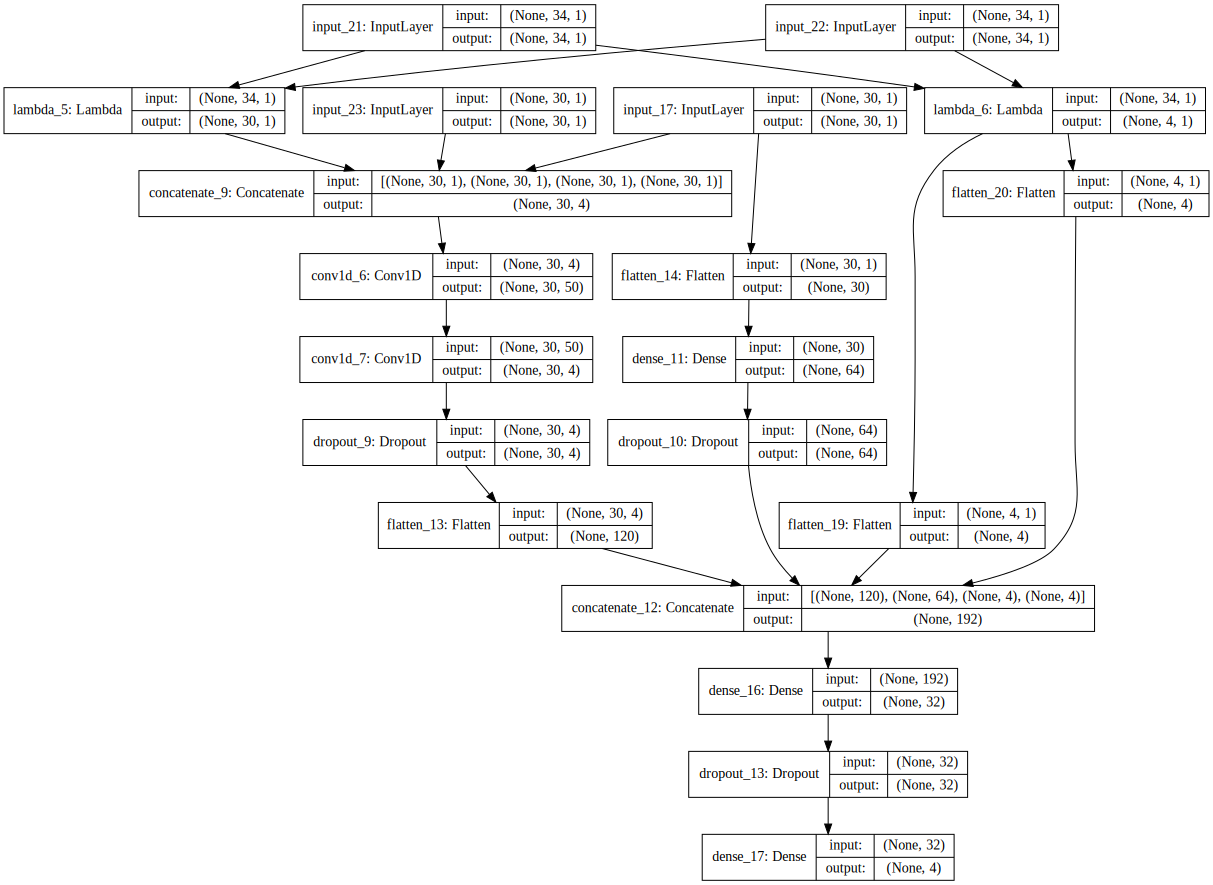

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
list(new_df.index.get_values())

[('강남점', '바네사브루노'),
 ('강남점', '질스튜어트'),
 ('강남점', '폴로랄프로렌'),
 ('건대스타점', '폴로랄프로렌'),
 ('광복점', '자딕앤볼테르'),
 ('광복점', '타임옴므'),
 ('노원점', '솔리드옴므'),
 ('노원점', '시스템옴므'),
 ('노원점', '질스튜어트'),
 ('노원점', '폴로랄프로렌'),
 ('본점', '바네사브루노'),
 ('본점', '산드로'),
 ('본점', '솔리드옴므'),
 ('본점', '시스템옴므'),
 ('본점', '에르메네질도 제냐'),
 ('본점', '엠포리오아르마니'),
 ('본점', '이자벨마랑'),
 ('본점', '자딕앤볼테르'),
 ('본점', '질스튜어트'),
 ('본점', '타임옴므'),
 ('본점', '폴로랄프로렌'),
 ('부산본점', '라움'),
 ('부산본점', '산드로'),
 ('부산본점', '에르메네질도 제냐'),
 ('부산본점', '질스튜어트'),
 ('부산본점', '질스튜어트뉴욕'),
 ('부산본점', '타임옴므'),
 ('부산본점', '폴로랄프로렌'),
 ('분당점', '폴로랄프로렌'),
 ('영등포점', '시스템옴므'),
 ('영등포점', '질스튜어트'),
 ('일산점', '솔리드옴므'),
 ('일산점', '폴로랄프로렌'),
 ('잠실점', '마쥬'),
 ('잠실점', '바네사브루노'),
 ('잠실점', '솔리드옴므'),
 ('잠실점', '시스템옴므'),
 ('잠실점', '자딕앤볼테르'),
 ('잠실점', '질스튜어트'),
 ('잠실점', '타임옴므'),
 ('창원점', '자딕앤볼테르'),
 ('창원점', '폴로랄프로렌'),
 ('평촌점', '시스템옴므'),
 ('평촌점', '폴로랄프로렌')]